# KeplerGl Visual Rendering

The goal of this notebook is to visually render various generated/acquired datasets using Uber's open-source KeplerGL.

## To do:
- explain how the data has been created

## 0. Modules and Auxilary Functions

#### The following cell contains the required imports:

In [1]:
from keplergl import KeplerGl
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import ast

%load_ext autoreload
%autoreload 2

#### Generates the important paths used in this notebook:

In [12]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from fremontdropbox import get_dropbox_location
dbx = get_dropbox_location()
print(dbx)
data_path = dbx + '/Private Structured data collection'
project_del_path = data_path + "/Manual-made dataset (do not touch)/Network/Map/Project Delimitation/Project_delimitation.shp"
map_path = data_path + "/Data processing/Kepler maps/Network/Map/"
inputs_path = data_path + '//Aimsun/Inputs/'
outputs_path = data_path + '/Aimsun/Outputs/'

/Users/daniel/Dropbox


#### Converts files into GeoDataframe objects:

In [22]:
def to_gdf(path):
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf = gdf.to_crs(epsg=4326)
    return gdf

def to_gdf_from_shp(filename):
    return to_gdf(inputs_path + filename)

def to_gdf_from_csv(path):
# https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-wkt-format
    df = pd.read_csv(path)
    gdf = gpd.GeoDataFrame(
        df, crs='epsg:4326', geometry=gpd.points_from_xy(df.x, df.y))
    return gdf

#### Prints diagnostic information for each table field:

In [23]:
def diagnostic_write(csv_file, tablename, table, table_map, field, fieldname, first=False, unit='', key=None):
    field_type = np.sort(field.unique())

    if first:
        csv_file.write("--------{}s-------\n".format(tablename))
        csv_file.write("Total number of {}s: {}\n".format(tablename, str(table['id'].count())))
        
    csv_file.write("{} {}, number of sections\n".format(fieldname, unit))

    if key:
        csv_file.write(key + '\n')

    for i in field_type:
        csv_file.write("{}, {}\n".format(str(i), str(table[table[fieldname] == i]['id'].count())))
        if True:
            table_map.add_data(data=table[table[fieldname] == i], name="{} {}".format(fieldname, str(i)))

    csv_file.write("\n")

#### Imports configuration files:

In [24]:
def get_configs(config_file='visualization_config.txt'):
    configs = open(config_file, 'r')
    config_dict = ast.literal_eval(configs.read())
    configs.close()
    return config_dict
    
def write_configs(config_dict, key, config, config_file='visualization_config.txt'):
    config_dict[key] = config
    print(config_dict, file=open(config_file, 'w'))

dict_config = get_configs()

In [25]:
def get_null_rows(df, col):
    return df[col.isnull()]

def get_not_null_rows(df, col):
    return df[col.notna()]

The following cell toggles printing debugging information:

In [26]:
print_kepler = True

## 1. Project delimitation

Project delimitation has been created in ...

In [27]:
project_del = to_gdf(project_del_path)

if print_kepler:
    del_map = KeplerGl(height=600)
    del_map.add_data(data = project_del[project_del.Type == "Delimitation"], name="Project delimitation")
    del_map.add_data(data = project_del[project_del.Type == "Box"], name="Project box delimitation")
    del_map.save_to_html(file_name=data_path+"/Data processing/Kepler maps/delimitation.html")
    del_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to /Users/daniel/Dropbox/Private Structured data collection/Data processing/Kepler maps/delimitation.html!


## 2. Network data

## To do: 
1. Get the different screenshot of the section characteristics (Theo)
2. Put the data in a CSV file (Theo)
3. Understand what is the meaning of node types and section function class
4. If possible render data about (Daniel M.):
    - traffic signal plans
    - master control plans
    - changes in network between 2013, 2017 and 2019
5. produce similar results with OSM directly (Ayush)

### 2.1 Map
#### Aimsun map

Aimsun map has been created in ...

In [28]:
# Get new demand
aimsun_complete = False

detectors = to_gdf_from_shp('detectors.shp')
meterings = to_gdf_from_shp('meterings.shp')
nodes = to_gdf_from_shp('nodes.shp')
sections = to_gdf_from_shp('sections.shp')
sectionsGeo = to_gdf_from_shp('sectionsGeo.shp')
turnings = to_gdf_from_shp('turnings.shp')
if aimsun_complete:
    centroids = to_gdf_from_shp('centroids.shp')
    centroid_connections = to_gdf_from_shp('centroid_connections.shp')
#     polygons = to_gdf_from_shp('polygons.shp')

#### The following cell is useful to better understand and render the network

## (Done) To do Edson: change print_diagnostic_information to get the information inside a csv file

In [29]:
# fremont_map = KeplerGl(height=600)
if print_kepler:
    node_map = KeplerGl(height=600)
    section_map = KeplerGl(height=600)
    speed_map = KeplerGl(height=600)
    capacity_map = KeplerGl(height=600)    
    func_type_map = KeplerGl(height=600)
    
section_key = "175 = Motorway, 177 = Primary, 179 = Residential, 180 = Secondary, 182.0 = Tertiary, 184.0 = Trunk, 185.0 = Unclassified"
speed_unit = "(km/h)"
capacity_unit = "(veh/h)"

# write diagnostic information to csv
diagnostic_csv = open("diagnostic_info.csv", 'w')
diagnostic_write(diagnostic_csv, "Node", nodes, node_map, nodes.nodetype, "nodetype", first = True)    

diagnostic_write(diagnostic_csv, "Section", sections, section_map, sections.rd_type, "rd_type", first = True, key = section_key)
diagnostic_write(diagnostic_csv, "Section", sections, speed_map, sections.speed, "speed", unit = speed_unit)
diagnostic_write(diagnostic_csv, "Section", sections, capacity_map, sections.capacity, "capacity", unit = capacity_unit)
diagnostic_write(diagnostic_csv, "Section", sections, func_type_map, sections.func_class, "func_class")
diagnostic_csv.close()

# fremont_map
if print_kepler:
    node_map.save_to_html(file_name = map_path + "nodes_to_check.html")
    section_map.save_to_html(file_name = map_path + "Sections/types.html")
    speed_map.save_to_html(file_name = map_path + "Sections/speed.html")
    capacity_map.save_to_html(file_name = map_path + "Sections/capacity.html")
    func_type_map.save_to_html(file_name = map_path + "Sections/funct_type.html")
    

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


FileNotFoundError: [Errno 2] No such file or directory: '/Users/daniel/Dropbox/Private Structured data collection/Data processing/Kepler maps/Network/Map/nodes_to_check.html'

In [30]:
if print_kepler:
    aimsun_map = KeplerGl(height=600)
    aimsun_map.add_data(data = detectors, name="Detectors")
    aimsun_map.add_data(data = meterings, name="meterings")
    aimsun_map.add_data(data = nodes, name="nodes")
    aimsun_map.add_data(data = sections, name="sections")
    aimsun_map.add_data(data = sectionsGeo, name="sectionsGeo")
    aimsun_map.add_data(data = turnings, name="turnings")
    if aimsun_complete:
        aimsun_map.add_data(data = centroids, name="centroids")
        aimsun_map.add_data(data = centroid_connections, name="centroid_connections")
#         fremont_map.add_data(data = polygons, name="polygons")
    aimsun_map.save_to_html(file_name=data_path+"/Data processing/Kepler maps/Network/aimsun_data.html")

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


FileNotFoundError: [Errno 2] No such file or directory: '/Users/daniel/Dropbox/Private Structured data collection/Data processing/Kepler maps/Network/aimsun_data.html'

#### Aimsun centroids and centroids connections

In [31]:
if print_kepler and aimsun_complete:
    centroid_map = KeplerGl(height=600, config=dict_config['centroid_config'])
    centroid_map.add_data(data = centroids[centroids['name'].str.contains('ext')], name="External centroids")
    centroid_map.add_data(data = centroids[centroids['name'].str.contains('int')], name="Internal centroids")
    centroid_map.add_data(data = centroid_connections, name="Centroid connections")
    centroid_map.add_data(data = centroid_connections[centroid_connections['direction'] == 'from'], name="Outgoing centroid connections")
    centroid_map.add_data(data = centroid_connections[centroid_connections['direction'] == 'to'], name="Incoming centroid connections")
    centroid_map.add_data(data = sections, name="sections")
    centroid_map.save_to_html(file_name=data_path+"/Data processing/Kepler maps/Network/Map/centroids.html")

#### Aimsun road section

In [ ]:
if print_kepler:
    road_section_map = KeplerGl(height=600, config=dict_config['road_type_config'])

    road_section_map.add_data(data = sections[sections['rd_type'] == 175.0], name="Motorway")
    road_section_map.add_data(data = sections[sections['rd_type'] == 177.0], name="Primary")
    road_section_map.add_data(data = sections[sections['rd_type'] == 179.0], name="Residential")
    road_section_map.add_data(data = sections[sections['rd_type'] == 180.0], name="Secondary")
    road_section_map.add_data(data = sections[sections['rd_type'] == 182.0], name="Tertiary")
    road_section_map.add_data(data = sections[sections['rd_type'] == 184.0], name="Trunk")
    road_section_map.add_data(data = sections[sections['rd_type'] == 185.0], name="Unclassified")
    road_section_map.save_to_html(file_name=data_path+"/Data processing/Kepler maps/Network/Map/sections.html")


In [ ]:
# road_type_config = road_section_map.config
# file = open("visualization_config.txt", 'w')
# file.write("{'road_type_config': " + str(road_type_config))
# file.write("}")
# file.close()

### 2.2 Infrastructure
#### Traffic signals and stop signs

Traffic signals and stop signs have been created in ...

## To do: get infrastructure data from OSM

In [ ]:
network_infra_path = data_path + "/Manual-made dataset (do not touch)/Network/Infrastructure/"

stop_signs = to_gdf_from_csv(network_infra_path + "Stop signs location/Stop_Signs.csv")
traffic_lights = to_gdf_from_csv(network_infra_path + "Traffic lights location/Traffic_Lights.csv")

In [ ]:
if print_kepler:
    intersections = KeplerGl(height=600)
    intersections.add_data(data = stop_signs, name="Stop signs")
    intersections.add_data(data = traffic_lights, name="Traffic lights")
    intersections.save_to_html(file_name=data_path+"/Data processing/Kepler maps/Network/Infrastructure/signs_and_lights.html")


## (Done) To do Edson: add the data in the following cell to the csv file for the Aimsun specs

In [ ]:
diagnostic_csv = open("diagnostic_info.csv", 'a') # append info to end of file
diagnostic_csv.write("Number of stop signs: " + str(stop_signs.__OBJECTID.count()) + "\n")
diagnostic_csv.write("Number of traffic lights: " + str(traffic_lights.__OBJECTID.count()) + "\n")
diagnostic_csv.close()

## (Done) |To do Edson: simplify if possible

In [ ]:
def create_kepler_map(dir_sections, dir_detectors, years):
    """
    Creates kepler map to be visualized in a notebook
    
    Parameters
    :param dir_sections: directory of sections.shp file 
    :param dir_detectors: directory of location_year_detector.shp files for all years
    """
    print("\nCreating Kepler Map")
    sections_df = gpd.GeoDataFrame.from_file(dir_sections + "sections.shp")
    sections_df = sections_df.to_crs(epsg=4326)
    sections_df = sections_df[['eid', 'geometry']] # remove unnecessary data
    sections_df = sections_df.rename(columns={'eid': 'Road_Id'})

    kepler_map = KeplerGl(height=600)
    kepler_map.add_data(data=sections_df, name='Road Sections')
    for year in years:
        shp_filename = "pems_detectors.shp" if year == 'PeMS' else ("location_%s_detector.shp" % year)

        detector_df = gpd.GeoDataFrame.from_file(dir_detectors + shp_filename)
        detector_df = detector_df.to_crs(epsg=4326)
        id_name = 'Id' if 'Id' in detector_df.columns else 'ID'
        detector_df = detector_df[[id_name, 'geometry']]
        detector_df = detector_df.rename(columns={id_name: 'Detector_Id'})

        kepler_map.add_data(data=detector_df, name='Detectors ' + year)

    return kepler_map

# import spatial_join as sj
data_process_folder = dbx + "/Private Structured data collection/Data processing/"
detectors_folder = data_process_folder + "Raw/Demand/Flow_speed/detectors/"
sections_folder = data_process_folder + "Raw/Network/Aimsun/"

# Visualize Fremont network with detectors
detector_years = ['2013', '2015', '2017', '2019', 'PeMS']
kepler_map = create_kepler_map(sections_folder, detectors_folder, detector_years)
kepler_map.save_to_html(file_name=data_process_folder + "Kepler maps/Network/Infrastructure/detectors.html")


## 3. Demand data

#### Raw demand:
- SFCTA demand data
- Fremont neighborhood

### 3.1 SFCTA demand data

In [ ]:
import datetime

def get_sfcta_dataframe(int_int_path, int_ext_path, ext_int_path):
    int_int_trips = pd.read_csv(int_int_path)
    int_ext_trips = pd.read_csv(int_ext_path)
    ext_int_trips = pd.read_csv(ext_int_path)

    internal_trips = pd.DataFrame.merge(int_int_trips, int_ext_trips, 'outer')
    internal_trips = pd.DataFrame.merge(internal_trips, ext_int_trips, 'outer')
    internal_trips['start_time'] = internal_trips['start_time'].apply(lambda x: pd.Timestamp(x))
    return internal_trips

def shift_time(demand_df, column):
    demand_df[column] += pd.to_timedelta(-8, unit='h')
    demand_df[column] = demand_df[column].apply(lambda x: x.time())
    
def get_demand_between_time(demand_df, begin_time, end_time):
    return demand_df[(demand_df.start_time >= begin_time) & (demand_df.start_time <= end_time)]
    
def cluster_demand_15min(df):
    demand_df = df.copy()
    demand_df['start_time'] = demand_df['start_time'].apply(lambda x: str(x.replace(minute=int(x.minute/15)*15,second = 0)))
    return demand_df.groupby(['start_time']).size().reset_index(name='counts')

SFCTA_path = data_path+ '/Data processing/Raw/Demand/OD demand/SFCTA demand data/'
int_int_path = SFCTA_path + "internal_fremont_legs.csv"
int_ext_path = SFCTA_path + "starting_fremont_legs.csv"
ext_int_path = SFCTA_path + "ending_fremont_legs.csv"

print("Loading SFCTA trips...")
internal_trips = get_sfcta_dataframe(int_int_path, int_ext_path, ext_int_path)
print("Shifting time...")
shift_time(internal_trips, 'start_time')
print("Get afternoon demand")
begin_time = datetime.time(14, 0, 0)
end_time = datetime.time(20, 0, 0)
afternoon_demand = get_demand_between_time(internal_trips, begin_time, end_time)
print("Clustering...")
clustered_internal_trips = cluster_demand_15min(internal_trips)
clustered_afternoon_trips = cluster_demand_15min(afternoon_demand)
print('Done')

In [ ]:
def print_demand_profile(df, every_nth, rot, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df.start_time, df.counts)
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    plt.xticks(rotation=rot)
    plt.title(title)
    plt.xlabel("time frame")
    plt.ylabel("trip count")
    plt.show()
    
print_demand_profile(clustered_internal_trips, 8, 60, "SFCTA demand profile full day")
print_demand_profile(clustered_afternoon_trips, 4, 45, "SFCTA demand profile afternoon")


## To do:
- do some check about the data using the processed data (especially demand profile and demand not assigned)

In [ ]:
from shapely.geometry import Point, LineString

def fxy(start_lat, start_lng, end_lat, end_lng):
    return LineString([(start_lng, start_lat), (end_lng, end_lat)])

begin_time = datetime.time(16, 0, 0)
end_time = datetime.time(16, 2, 0)

if print_kepler:
    afternoon_demand['geometry'] = afternoon_demand.apply(lambda x: fxy(x['start_node_lat'], x['start_node_lng'], x['end_node_lat'], x['end_node_lng']), axis=1)
    afternoon_demand_gpd = gpd.GeoDataFrame(afternoon_demand, crs='epsg:4326', geometry = afternoon_demand.geometry)
    demand_in_time = afternoon_demand_gpd[(afternoon_demand_gpd.start_time >= begin_time) & (afternoon_demand_gpd.start_time <= end_time)]

    demand_map = KeplerGl(height=600)
    demand_map.add_data(data = demand_in_time[['leg_id','geometry']], name="Demand")
    demand_map.save_to_html(file_name=data_path+"/Data processing/Kepler maps/Demand/SFCTA_1600_1602.html")
    

### 3.2 Transportation Analysis Zones

#### External TAZs
#### Neighborhoods
#### Internal TAZs
## To do

In [23]:
from shapely.geometry import Point, LineString

if print_kepler:
    path_taz = data_path + "/Manual-made dataset (do not touch)/Demand/OD demand/External TAZ/External Centroid zones/"
    external_taz = to_gdf(path_taz + "/ExternalCentroidZones.shp")
    external_taz_map = KeplerGl(height=600)
    external_taz_map.add_data(data = external_taz, name="External TAZs")
    external_taz_map.save_to_html(file_name=data_path+"/Data processing/Kepler maps/Demand/External_TAZs.html")
    
## to do: neighborhood - internal TAZs (all togethers)
    

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to /Users/theophile/Dropbox/Private Structured data collection/Data processing/Kepler maps/Demand/External_TAZs.html!


#### Centroid connections

In [24]:
## to do from Ayush code

### 3.3 OD demand


## (Done, Question below) To do Edson: 
- put this in a function and debug (the issue might be an issue of ESPG)
- Does putting in a function mean a python file or just a function here in the notebook

In [40]:
from shapely.geometry import Point, LineString

def get_gdf(path):
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf = gdf.set_geometry('geometry')
    gdf = gdf.to_crs(epsg=4326)
    return gdf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

path_taz = data_path + "/Data processing/Auxiliary files/Demand/OD demand/TAZ"
internal_taz = get_gdf(path_taz + "/Internal_TAZ.shp")
# external_taz = get_gdf(path_taz + "/External_TAZ.shp")
external_centroids = get_gdf(path_taz + "/External_centroids.shp")

# Get gravity centers for all TAZs (internal and external)
centroid_gravity = {}
for i in range(len(internal_taz['geometry'])):
    centroid_gravity[internal_taz['CentroidID'][i]] = internal_taz['geometry'][i].centroid
for i in range(len(external_centroids['geometry'])):
    centroid_gravity[external_centroids['CentroidID'][i]] = external_centroids['geometry'][i]

od_demand_path = data_path + "/Data processing/Temporary exports to be copied to processed data/Demand/OD demand/" 
internal_od = pd.read_csv(od_demand_path + "Internal OD grouped by timestamp.csv")
external_od = pd.read_csv(od_demand_path + "External OD grouped by timestamp.csv")

# Remove centroids with no demand
external_od = external_od[external_od["counts"] != 0]
internal_od = internal_od[internal_od["counts"] != 0]

# Fix analysis timestep at 6 PM
internal_od_6_pm = internal_od[internal_od["dt_15"]=="18:00:00"]
external_od_6_pm = external_od[external_od["dt_15"]=="18:0"]

internal_od_6_pm = internal_od_6_pm.reset_index()
external_od_6_pm = external_od_6_pm.reset_index()

external_demand = gpd.GeoDataFrame(columns=['CentroidID_O', 'CentroidID_D', "counts", 'geometry'])
for i in range(len(external_od_6_pm['CentroidID_O'])):
    origin_id = external_od_6_pm['CentroidID_O'][i]
    dest_id = external_od_6_pm['CentroidID_D'][i]
    demand = external_od_6_pm['counts'][i]
    external_demand.loc[i] = [origin_id, dest_id, demand, LineString([centroid_gravity[origin_id], centroid_gravity[dest_id]])]

internal_demand = gpd.GeoDataFrame(columns=['CentroidID_O', 'CentroidID_D', "counts", 'geometry'])
int_ext_demand = gpd.GeoDataFrame(columns=['CentroidID_O', 'CentroidID_D', "counts", 'geometry'])
for i in range(len(internal_od_6_pm['CentroidID_O'])):
    origin_id = internal_od_6_pm['CentroidID_O'][i]
    dest_id = internal_od_6_pm['CentroidID_D'][i]
    demand = internal_od_6_pm['counts'][i]
    if origin_id in centroid_gravity and dest_id in centroid_gravity:
        if "ext" not in origin_id and "ext" not in dest_id:
            internal_demand.loc[i] = [origin_id, dest_id, demand, LineString([centroid_gravity[origin_id], centroid_gravity[dest_id]])]
        else:
                int_ext_demand.loc[i] = [origin_id, dest_id, demand, LineString([centroid_gravity[origin_id], centroid_gravity[dest_id]])]

print("Number of Vehicles Analyzed at 6 PM (Internal):", internal_od_6_pm.counts.sum())
print("Number of Vehicles Analyzed at 6 PM (External):", external_od_6_pm.counts.sum())
print("Number of Vehicles Analyzed at 6 PM (Total):", internal_od_6_pm.counts.sum() + external_od_6_pm.counts.sum())

if print_kepler:
    demand_6_pm_map = KeplerGl(height=600, config=dict_config["OD Demand"])
    demand_6_pm_map.add_data(data = external_centroids, name="External Centroids")

    int_batches = {"Internal Demand":[(0, 2), (2, 3), (3, 4), (4, 5), (5, float('inf'))]}
    int_ext_batches = {"Internal/External Demand":[(0, 2), (5, 10), (10, 15), (15, float('inf'))]}
    ext_batches = {"External Demand":[(0, 10), (10, 50), (50, 250), (250, float('inf'))]}
    dem_map = {"Internal Demand":internal_demand, "Internal/External Demand":int_ext_demand, "External Demand":external_demand}

    for batch_list in [int_batches, int_ext_batches, ext_batches]:
        for b_name, batches in batch_list.items():
            for batch in batches:
                demand_6_pm_map.add_data(data = dem_map[b_name][(dem_map[b_name]['counts'] >= batch[0])\
                                            & (dem_map[b_name]['counts'] < batch[1])],\
                                     name="{} in [{},{}) veh/15 min".format(b_name, batch[0], batch[1]))

    demand_6_pm_map.add_data(data = internal_taz, name="Internal TAZs")

    demand_6_pm_map.save_to_html(file_name=data_path+"/Data processing/Kepler maps/Demand/6pm_demand_batches_map.html")
    

Number of Vehicles Analyzed at 6 PM (Internal): 3642
Number of Vehicles Analyzed at 6 PM (External): 1263
Number of Vehicles Analyzed at 6 PM (Total): 4905
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to /Users/edson/Dropbox/Private Structured data collection/Data processing/Kepler maps/Demand/6pm_demand_batches_map.html!


In [ ]:
# Serializing KeplerGl config for 7_6pm_demand_batches_map.html
'''
write_configs(dict_config, "OD Demand", fremont_map.config)
dict_config = get_configs()
'''

## 4. Traffic data

### 4.1 Flow data

## To do

## To do Edson:
- for all detectors in 2019 save the flow profile for the entire day and for the afternoon (1pm-8pm). 

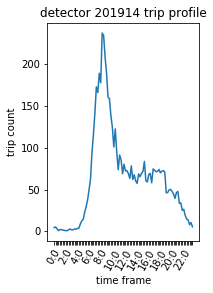

In [53]:
#2019 city detector info

# city_detector_geo = pd.read_csv(data_path + '/Data processing/Auxiliary files/Network/Infrastructure/Detectors/Detectors_old/detectors_2019.csv')

# city detector flow info
city_detector_flow = pd.read_csv(data_path + '/Data processing/Auxiliary files/Demand/Flow_speed/flow_processed_2019.csv')


def city_detector_plot(city_detector_id):
    """
    Plot the demand profile specified city detector ID (integer with format 2019XX)
    """
    curr_detector_flow = city_detector_flow[city_detector_flow['Detector_Id'] == city_detector_id]
    curr_detector_flow = curr_detector_flow.transpose()[5:]
    curr_detector_flow['dt_15'] = curr_detector_flow.index
    curr_detector_flow.index = range(len(curr_detector_flow))
    curr_detector_flow.columns = ['count', 'dt_15']
    cols = curr_detector_flow.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    curr_detector_flow = curr_detector_flow[cols]
    curr_detector_flow = curr_detector_flow.rename(columns={'count': 'Flow (Veh/15min)'})
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.plot(curr_detector_flow.dt_15, curr_detector_flow['Flow (Veh/15min)'])

#     ax1 = fig.add_subplot(122)
#     one_pm = 13*4
#     eight_pm = 20*4
#     print(curr_detector_flow.dt_15[one_pm: eight_pm])
#     print(curr_detector_flow['Flow (Veh/15min)'][one_pm: eight_pm])
#     ax1.plot(curr_detector_flow.dt_15[one_pm: eight_pm], curr_detector_flow['Flow (Veh/15min)'][one_pm: eight_pm])
    
    every_nth = 8
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    plt.xticks(rotation=60)
    plt.title("detector " + str(city_detector_id) +" trip profile")
    plt.xlabel("time frame")
    plt.ylabel("trip count")
    plt.show()
    
city_detector_plot(201914)

### 4.2 Speed data

## To do

### 4.3 Trajectory data

In [32]:
vehSectTraj = pd.read_csv(outputs_path + '/vehSectTrajectory.csv')

vehSectTraj_temp = vehSectTraj.groupby("sectionId").mean()
section_sim_data = pd.merge(sections, vehSectTraj_temp,
                        left_on='id', right_on='sectionId', how='left', sort=True)

In [33]:
trajectory_map = KeplerGl(height=800)
trajectory_map.add_data(data=get_null_rows(section_sim_data, section_sim_data.travelTime), name = "Sections without traffic")
trajectory_map.add_data(data=get_not_null_rows(section_sim_data, section_sim_data.travelTime), name = "Sections with traffic")
section_sim_data.crs = 'epsg:4326'
trajectory_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'Sections without traffic': {'index': [3, 4, 20, 21, 22, 23, 24, 25, 33, 35, 36, 37, 38, 39, 40…

### 4.4 Travel time data

## To do
from Travel time pipeline

## 5. Validation data

## To do: add the biplots here
from Aimsun analyser pipeline

## Key performance indicators

## To do:
- travel time distribution
- isochrone

from KPI pipeline

## The following is to do later

## Open Street Map

In [ ]:
import ogr

driver=ogr.GetDriverByName('OSM')
path_osm = data_path + "/Raw data (do not touch)/Network/Map/OSM/"


data = driver.Open(path_osm + 'map1111.osm')

for i in range(data.GetLayerCount()):
    print(data.GetLayerByIndex(i).GetName())
    
layer = data.GetLayer('points')

features=[x for x in layer]
print(len(features))

data_list=[]
i = 0
for feature in features:
    i = i + 1
    data=feature.ExportToJson(as_object=True)
    coords=data['geometry']['coordinates']
    shapely_geo=Point(coords[0],coords[1])
    name=data['properties']['name']
    highway=data['properties']['highway']
    print(highway)
    other_tags=data['properties']['other_tags']
    if other_tags and 'amenity' in other_tags:
        feat=[x for x in other_tags.split(',') if 'amenity' in x][0]
        amenity=feat[feat.rfind('>')+2:feat.rfind('"')]
    else:
        amenity=None
    data_list.append([name,highway,amenity,shapely_geo])
    if i > 20:
        break
# gdf=gpd.GeoDataFrame(data_list,columns=['Name','Highway','Amenity','geometry'],crs={'init': 'epsg:4326'}).to_crs(epsg=3310)